In [2]:
import os
import math
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

<ipython-input-2-cb33373d5d47>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
#recupera i dati EOD per EUR/USD
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
symbol = 'EUR='
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                               parse_dates=True).dropna()[symbol])

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


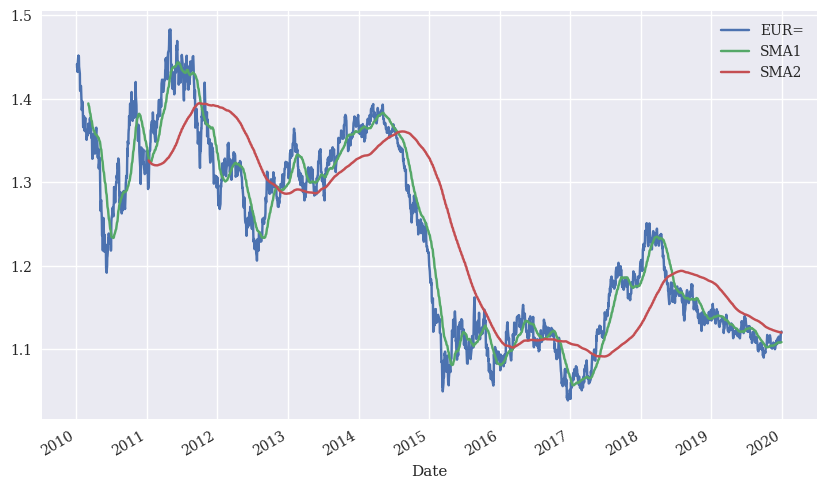

In [4]:
#calcola la SMA più breve
data['SMA1'] = data[symbol].rolling(42).mean()

#calcola la SMA più lunga
data['SMA2'] = data[symbol].rolling(258).mean()

#mostra le tre serie temporali
data.plot(figsize=(10, 6)); 

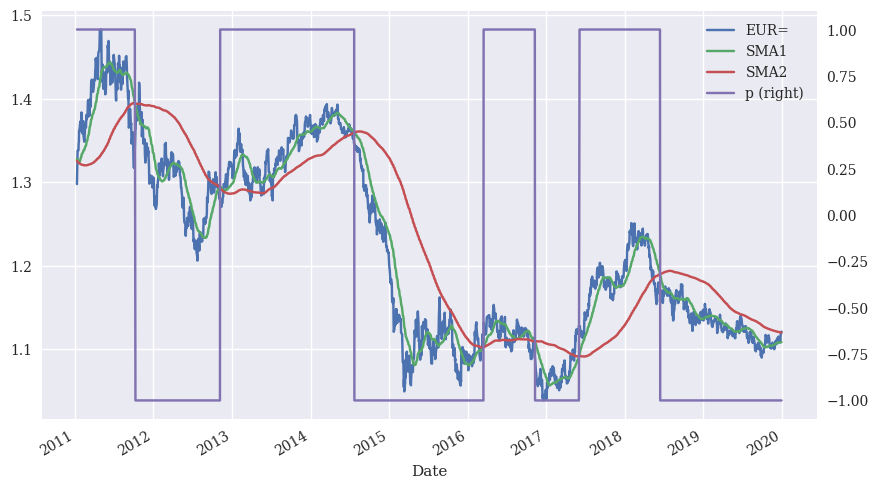

In [5]:
#elimina le righe contenenti i valori NaN
data.dropna(inplace=True)

#deriva i valori di posizione in base ai valori SMA dello stesso giorno
data['p'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

#sposta i valori di posizione di un giorno per evitare errori di previsione
data['p'] = data['p'].shift(1)

data.dropna(inplace=True)

#mostra i valori di posizione derivanti dagli SMA
data.plot(figsize=(10, 6), secondary_y='p');

In [6]:
#calcola i rendimenti logaritmici
data['r'] = np.log(data[symbol] / data[symbol].shift(1))
data.dropna(inplace=True)

#calcola i rendimenti della strategia
data['s'] = data['p'] * data['r']

#calcola le prestazioni lorde
data[['r', 's']].sum().apply(np.exp) 

r   0.8640
s   1.3773
dtype: float64

In [7]:
#calcola le prestazioni nette
data[['r', 's']].sum().apply(np.exp) - 1 

r   -0.1360
s    0.3773
dtype: float64

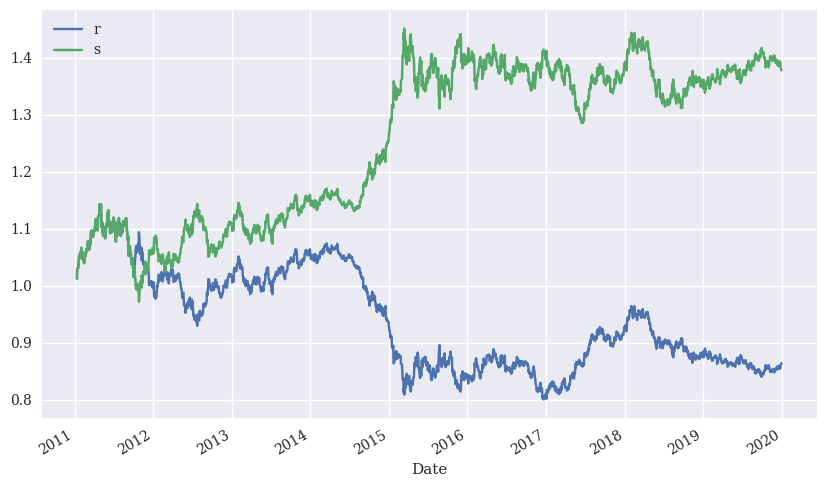

In [8]:
#mostra le prestazioni lorde nel tempo
data[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6)); 

In [9]:
#calcola il numero di negoziazioni, comprese le negoziazioni in entreta e in uscita
sum(data['p'].diff() != 0) + 2 

#corregge i costi di transazione proporzionali (deliberatamente impostati piuttosto alti)
pc = 0.005

#regola le prestazioni della strategia per i costi di transazione
data['s_'] = np.where(data['p'].diff() != 0,
                      data['s'] - pc, data['s'])

#regola le prestazioni della strategia per l'entry trade
data['s_'].iloc[0] -= pc 

#regola le prestazioni della strategia per l'exit trade
data['s_'].iloc[-1] -= pc

#mostra i valori di performance rettificati per le negoziazioni regolari
data[['r', 's', 's_']][data['p'].diff() != 0]

,r,s,s_
Date,,,
2011-01-12,0.0123,0.0123,0.0023
2011-10-10,0.0198,-0.0198,-0.0248
2012-11-07,-0.0034,-0.0034,-0.0084
2014-07-24,-0.0001,0.0001,-0.0049
2016-03-16,0.0102,0.0102,0.0052
2016-11-10,-0.0018,0.0018,-0.0032
2017-06-05,-0.0025,-0.0025,-0.0075
2018-06-15,0.0035,-0.0035,-0.0085


In [10]:
data[['r', 's', 's_']].sum().apply(np.exp)

r    0.8640
s    1.3773
s_   1.3102
dtype: float64

In [11]:
data[['r', 's', 's_']].sum().apply(np.exp) - 1

r    -0.1360
s     0.3773
s_    0.3102
dtype: float64

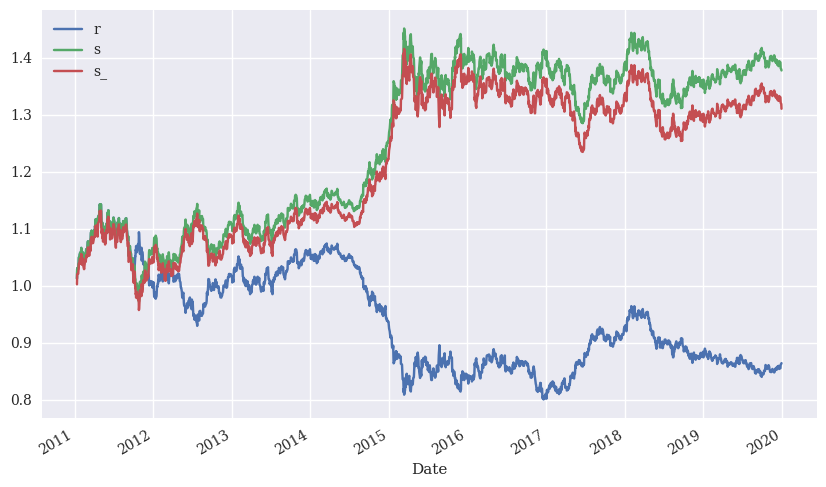

In [12]:
data[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [13]:
#volatilità giornaliera
data[['r', 's', 's_']].std() 

r    0.0054
s    0.0054
s_   0.0054
dtype: float64

In [14]:
#volatilità annualizzata
data[['r', 's', 's_']].std() * math.sqrt(252)

r    0.0853
s    0.0853
s_   0.0855
dtype: float64

In [15]:
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                    parse_dates=True).dropna()[symbol])

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [16]:
lags = 5

def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift(1))
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

data, cols = add_lags(data, symbol, lags, window=20)

In [17]:
import random
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

optimizer = Adam(learning_rate=0.0001)

def create_model(hl=2, hu=128, dropout=False, rate=0.3,
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
       reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    activity_regularizer=reg,
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                      activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [18]:
#suddivide i dati in dati di addestramento e dati di test
split = '2018-01-01'
train = data.loc[:split].copy()

#mostra la frequenza delle classi di etichette
np.bincount(train['d'])

array([ 982, 1006])

In [19]:
#normalizza i dati delle features di addestramento
mu, std = train.mean(), train.std()
train_ = (train - mu) / std

set_seeds()

#crea il modello DNN
model = create_model(hl=2, hu=64) 

#addestra il modello DNN sui dati di addestramento
model.fit(train_[cols], train['d'],
          epochs=20, verbose=False,
          validation_split=0.2, shuffle=False)

In [20]:
#valuta le prestazioni del modello sui dati di addestramento
model.evaluate(train_[cols], train['d']) 

63/63 [==============================] - 0s 2ms/step - loss: 0.6748 - accuracy: 0.5951


[0.6748248338699341, 0.5950704216957092]

In [21]:
#genera le previsioni binarie
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, 0) 

#converte le previsioni in valori di posizione
train['p'] = np.where(train['p'] == 1, 1, -1)

#mostra il numero di posizioni long e short
train['p'].value_counts()

63/63 [==============================] - 0s 1ms/step


-1    1125
 1     863
Name: p, dtype: int64

In [22]:
#calcola i valori delle prestazioni della strategia
train['s'] = train['p'] * train['r']

#calcola le prestazioni lorde e nette (nel campione)
train[['r', 's']].sum().apply(np.exp)

r   0.8787
s   5.3770
dtype: float64

In [23]:
train[['r', 's']].sum().apply(np.exp)  - 1 

r   -0.1213
s    4.3770
dtype: float64

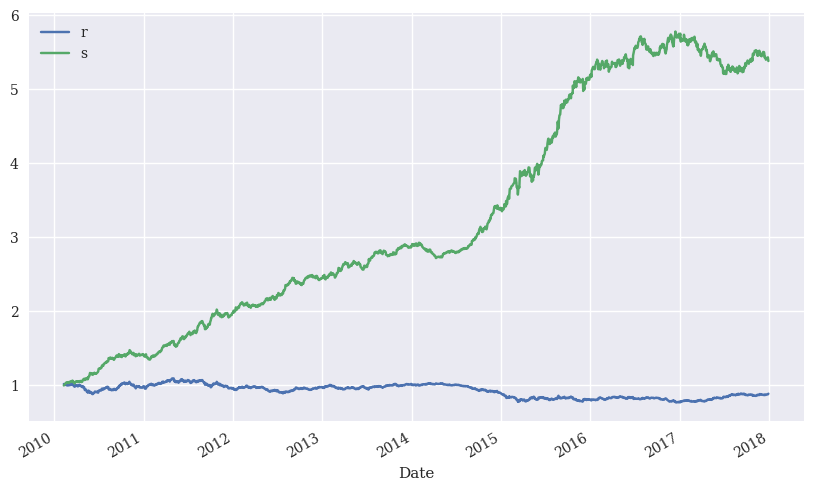

In [24]:
#mostra le prestazioni lorde nel tempo (nel campione)
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6)); 

In [25]:
#genera il sottoinsieme di dati di test
test = data.loc[split:].copy() 

#normalizza i dati di test
test_ = (test - mu) / std

#valuta le prestazioni del modello sui dati di test
model.evaluate(test_[cols], test['d'])

16/16 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0.5149


[0.6952627897262573, 0.5149105191230774]

In [26]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)
test['p'].value_counts()

16/16 [==============================] - 0s 1ms/step


-1    417
 1     86
Name: p, dtype: int64

In [27]:
test['s'] = test['p'] * test['r']

test[['r', 's']].sum().apply(np.exp)

r   0.9345
s   1.0472
dtype: float64

In [28]:
test[['r', 's']].sum().apply(np.exp) - 1

r   -0.0655
s    0.0472
dtype: float64

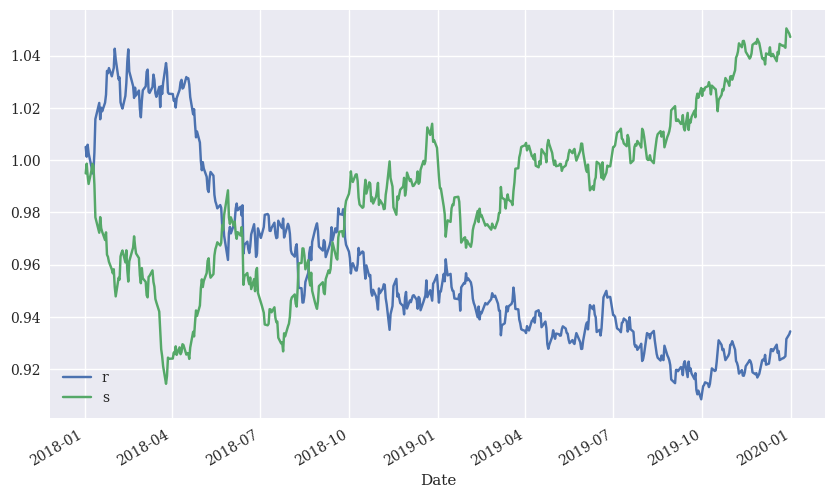

In [29]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [30]:
sum(test['p'].diff() != 0)

137

In [31]:
#corregge lo spread bid-ask medio
spread = 0.00012 

#calcola i costi di transazione proporzionali medi
pc = spread / data[symbol].mean()

print(f'{pc:.6f}')

0.000098


In [32]:
test['s_'] = np.where(test['p'].diff() != 0,
                      test['s'] - pc, test['s'])

In [33]:
test['s_'].iloc[0] -= pc
test['s_'].iloc[-1] -= pc
test[['r', 's', 's_']].sum().apply(np.exp)

r    0.9345
s    1.0472
s_   1.0331
dtype: float64

In [34]:
test[['r', 's', 's_']].sum().apply(np.exp) - 1

r    -0.0655
s     0.0472
s_    0.0331
dtype: float64

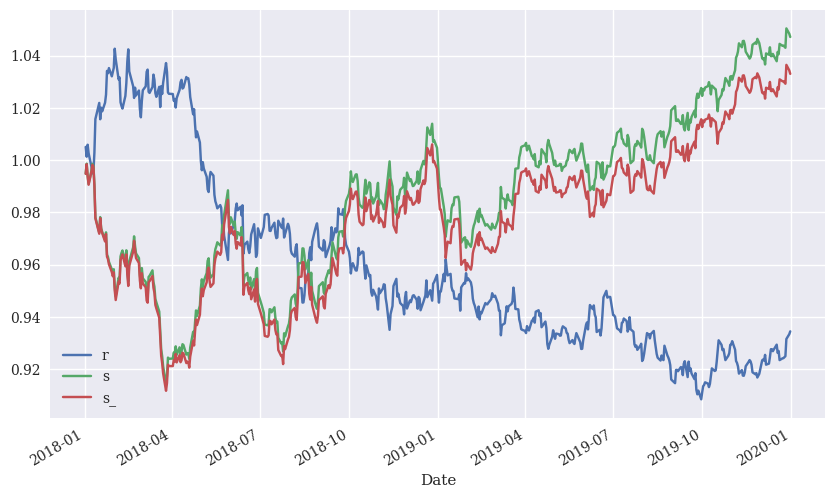

In [35]:
test[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [36]:
#recupera i dati intraday per EUR/USD e seleziona i prezzi di chisura
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv' 

symbol = 'EUR=' 
data = pd.DataFrame(pd.read_csv(url, index_col=0,
                    parse_dates=True).dropna()['CLOSE'])
data.columns = [symbol]

#ricampiona i dati in barre di cinque minuti
data = data.resample('5min', label='right').last().ffill() 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26486 entries, 2019-10-01 00:05:00 to 2019-12-31 23:10:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EUR=    26486 non-null  float64
dtypes: float64(1)
memory usage: 413.8 KB


In [37]:
lags = 5

data, cols = add_lags(data, symbol, lags, window=20)

In [38]:
split = int(len(data) * 0.85)
train = data.iloc[:split].copy()
np.bincount(train['d'])

def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

mu, std = train.mean(), train.std()

train_ = (train - mu) / std

set_seeds()
model = create_model(hl=1, hu=128,
                     reg=True, dropout=False)

model.fit(train_[cols], train['d'],
          epochs=40, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

model.evaluate(train_[cols], train['d'])

703/703 [==============================] - 1s 1ms/step - loss: 0.5254 - accuracy: 0.6697


[0.5254268050193787, 0.6696900725364685]

In [39]:
train['p'] = np.where(model.predict(train_[cols]) > 0.5, 1, -1)
train['p'].value_counts()

703/703 [==============================] - 1s 2ms/step


 1    11254
-1    11237
Name: p, dtype: int64

In [40]:
train['s'] = train['p'] * train['r']

train[['r', 's']].sum().apply(np.exp)

r   1.0223
s   1.6695
dtype: float64

In [41]:
train[['r', 's']].sum().apply(np.exp) - 1

r   0.0223
s   0.6695
dtype: float64

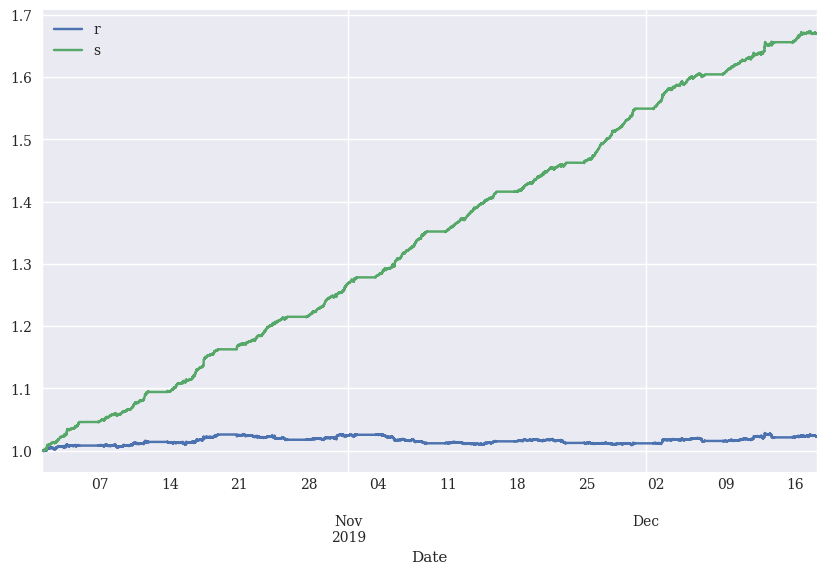

In [42]:
train[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [43]:
test = data.iloc[split:].copy()
test_ = (test - mu) / std
model.evaluate(test_[cols], test['d'])

125/125 [==============================] - 0s 2ms/step - loss: 0.5336 - accuracy: 0.6572


[0.5335637331008911, 0.6571788191795349]

In [44]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, -1)
test['p'].value_counts()

125/125 [==============================] - 0s 2ms/step


-1    2052
 1    1918
Name: p, dtype: int64

In [45]:
test['s'] = test['p'] * test['r']
test[['r', 's']].sum().apply(np.exp)

r   1.0071
s   1.0694
dtype: float64

In [46]:
test[['r', 's']].sum().apply(np.exp) - 1

r   0.0071
s   0.0694
dtype: float64

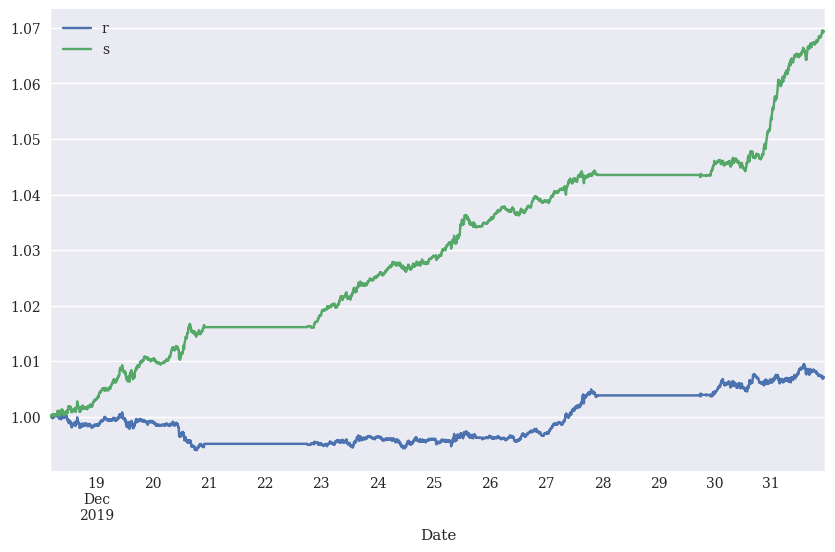

In [47]:
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [48]:
sum(test['p'].diff() != 0)

1231

In [49]:
#presuppone lo spread bid-ask a livello di vendita al dettaglio
spread = 0.00012
pc_1 = spread / test[symbol]
test['s_1'] = np.where(test['p'].diff() != 0,
                       test['s'] - pc_1, test['s'])
test['s_1'].iloc[0] -= pc_1.iloc[0]
test['s_1'].iloc[-1] -= pc_1.iloc[0]

#presuppone lo spread bid-ask a livello professionale
spread = 0.00006
pc_2 = spread / test[symbol]
test['s_2'] = np.where(test['p'].diff() != 0,
                        test['s'] - pc_2, test['s'])
test['s_2'].iloc[0] -= pc_2.iloc[0]
test['s_2'].iloc[-1] -= pc_2.iloc[0] 

In [50]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp)

r     1.0071
s     1.0694
s_1   0.9362
s_2   1.0006
dtype: float64

In [51]:
test[['r', 's', 's_1', 's_2']].sum().apply(np.exp) - 1

r      0.0071
s      0.0694
s_1   -0.0638
s_2    0.0006
dtype: float64

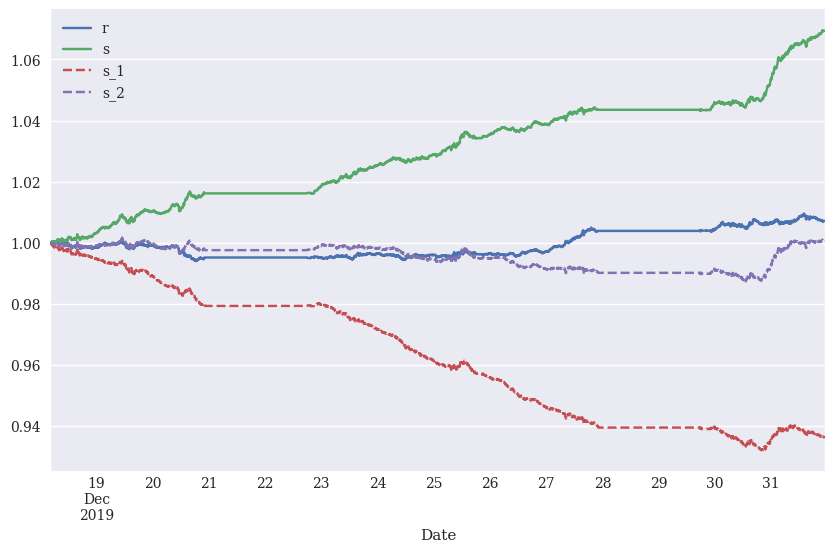

In [52]:
test[['r', 's', 's_1', 's_2']].cumsum().apply(
     np.exp).plot(figsize=(10, 6), style=['-', '-', '--', '--']);